In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from sklearn.metrics import mean_squared_error, mean_absolute_error

TypeError: Descriptors cannot not be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

In [3]:
bitcoin = pd.read_csv("bitcoin.csv")
bitcoin.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-09-13,235.242004,235.934998,229.332001,230.511993,230.511993,18478800.0
1,2015-09-14,230.608994,232.440002,227.960999,230.643997,230.643997,20997800.0
2,2015-09-15,230.492004,259.182007,229.822006,230.304001,230.304001,19177800.0
3,2015-09-16,230.250000,231.214996,227.401993,229.091003,229.091003,20144200.0
4,2015-09-17,229.076004,230.285004,228.925995,229.809998,229.809998,18935400.0


In [6]:
bitcoin.shape

(2193, 7)

In [7]:
bitcoin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2193 entries, 0 to 2192
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2193 non-null   object 
 1   Open       2189 non-null   float64
 2   High       2189 non-null   float64
 3   Low        2189 non-null   float64
 4   Close      2189 non-null   float64
 5   Adj Close  2189 non-null   float64
 6   Volume     2189 non-null   float64
dtypes: float64(6), object(1)
memory usage: 120.1+ KB


In [8]:
total = bitcoin.isnull().sum().sort_values(ascending=False)
percent = (bitcoin.isnull().sum()/bitcoin.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
Open,4,0.001824
High,4,0.001824
Low,4,0.001824
Close,4,0.001824
Adj Close,4,0.001824
Volume,4,0.001824
Date,0,0.000000


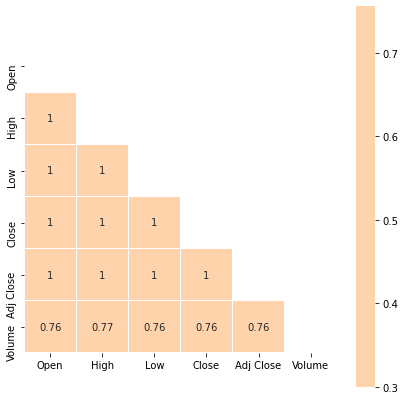

In [9]:
#Plotting correlation
plt.figure(figsize=(7,7))
corr=bitcoin[bitcoin.columns[1:]].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(bitcoin[bitcoin.columns[1:]].corr(), mask=mask, vmax=.3, center=0,
square=True, linewidths=.5,annot=True)
plt.show()

<AxesSubplot:xlabel='Volume'>

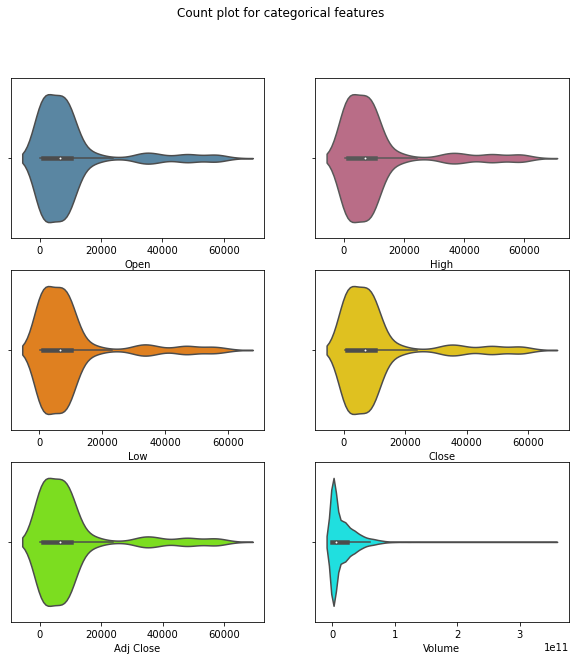

In [10]:
fig,axes = plt.subplots(3,2,figsize = (10,10))
fig.suptitle("Count plot for categorical features")
#Open
sns.violinplot(ax=axes[0,0],data=bitcoin,x='Open',color='#4e89ae')
#High
sns.violinplot(ax=axes[0,1],data=bitcoin,x='High',color='#c56183')
#Low
sns.violinplot(ax=axes[1,0],data=bitcoin,x='Low',color='#ff8000')
#Close
sns.violinplot(ax=axes[1,1],data=bitcoin,x='Close',color='#ffd700')
#Adj Close
sns.violinplot(ax=axes[2,0],data=bitcoin,x='Adj Close',color='#7cfC00')
#Volume
sns.violinplot(ax=axes[2,1],data=bitcoin,x='Volume',color='#00FFFF')

In [11]:
bitcoin['Volume'].fillna(value=0, inplace=True)
bitcoin['Open'].fillna(method='ffill', inplace=True)
bitcoin['High'].fillna(method='ffill', inplace=True)
bitcoin['Low'].fillna(method='ffill', inplace=True)
bitcoin['Close'].fillna(method='ffill', inplace=True)
bitcoin['Adj Close'].fillna(method='ffill', inplace=True)

In [12]:
bitcoin['Date'] = pd.to_datetime(bitcoin['Date'])
bitcoin.rename(columns = {'Close':'Price'}, inplace = True)

In [13]:
bitcoin['Date'] = bitcoin['Date'].dt.tz_localize(None)
bitcoin = bitcoin.set_index('Date')
bitcoin = bitcoin[['Price']]

In [14]:
#Splitting data
split_date = '2020-02-25'
data_train = bitcoin.loc[bitcoin.index <= split_date].copy()
data_test = bitcoin.loc[bitcoin.index > split_date].copy()


In [15]:
#Data preprocessing
training_set = data_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))

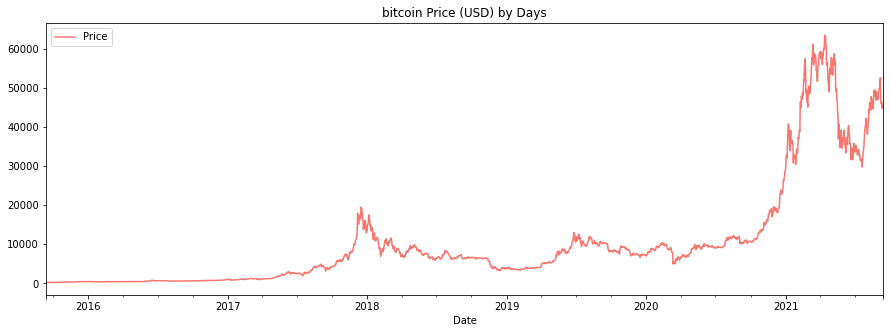

In [16]:
#Historical price
_ = bitcoin.plot(style='', figsize=(15,5), color="#F8766D", title='bitcoin Price (USD) by Days')

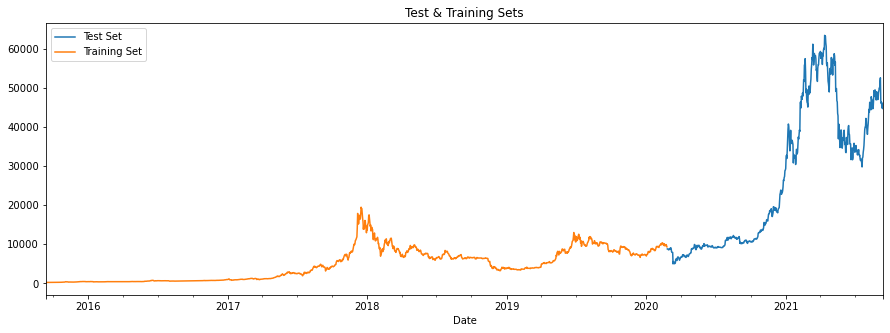

In [17]:
#Plotting the test and training sets
_ = data_test.rename(columns={'Price': 'Test Set'}).join(data_train.rename(columns={'Price': 'Training Set'}), how='outer').plot(figsize=(15,5), title='Test & Training Sets', style='')

In [18]:
#Creating the model
model = Sequential()
model.add(LSTM(128,activation="sigmoid",input_shape=(1,1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=50, verbose=2)

NameError: name 'Sequential' is not defined

In [ ]:
model.summary()

In [ ]:
#Making the predictions
test_set = data_test.values
inputs = np.reshape(test_set, (len(test_set), 1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))
predicted_BIT_price = model.predict(inputs)
predicted_BIT_price = sc.inverse_transform(predicted_BIT_price)

In [ ]:
data_test['Price_Prediction'] = predicted_BIT_price
data_all = pd.concat([data_test, data_train], sort=False)

In [ ]:
data_all

In [ ]:
_ = data_all[['Price','Price_Prediction']].plot(figsize=(15, 5))

In [ ]:
#Plotting the forecast v/s actual price
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = data_all[['Price_Prediction','Price']].plot(ax=ax)
ax.set_xbound(lower='01-02-2021', upper='20-05-2021')
plot = plt.suptitle('Bitcoin :: Jan to May, Forecast vs Actual')

In [ ]:
#MSE
mean_squared_error(y_true=data_test['Price'],y_pred=data_test['Price_Prediction'])

In [ ]:
#MAE
mean_absolute_error(y_true=data_test['Price'],y_pred=data_test['Price_Prediction'])